# Group Outlier Detection

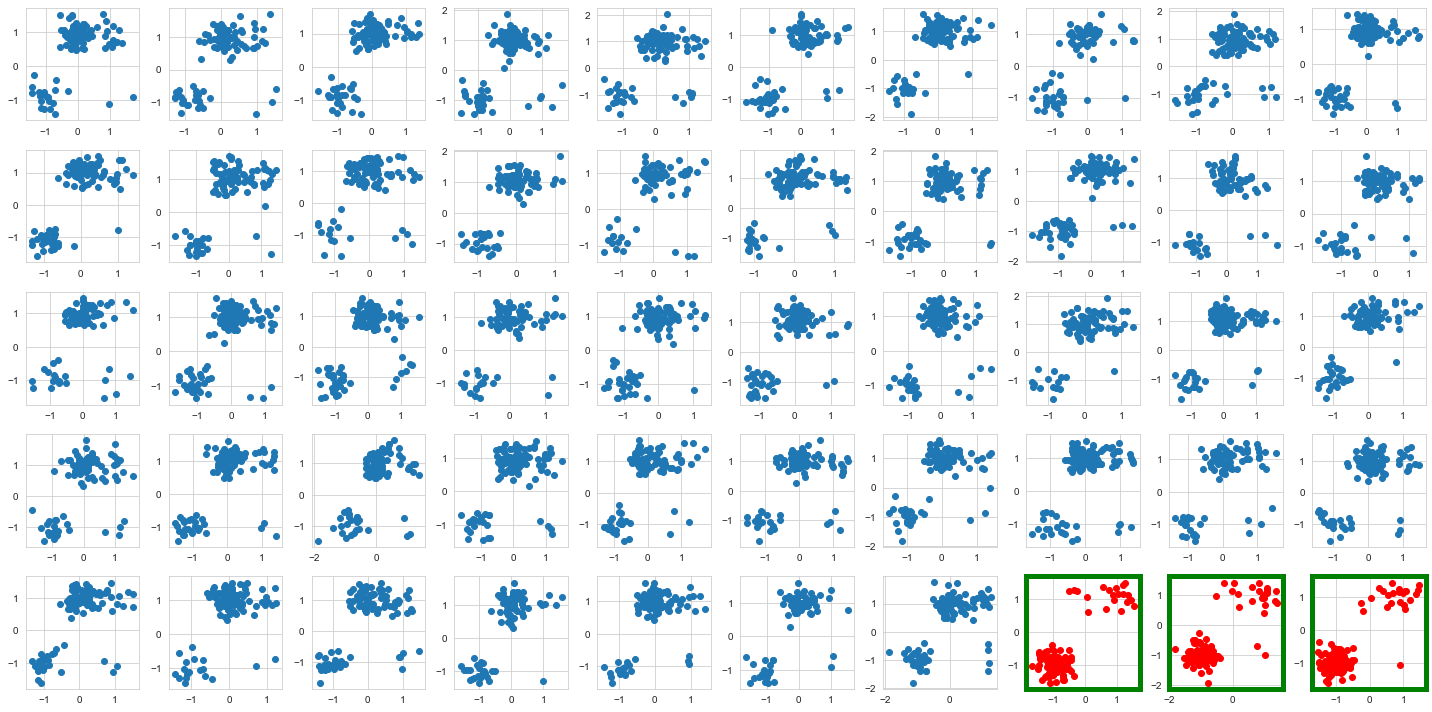

<Figure size 432x288 with 0 Axes>

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from utils_data.synthetic_mixtures import generate_mixtures
from utils_visualization import plot_mixtures
from utils_visualization import plot_roc_curve, plot_roc_curves

mixtures_df = generate_mixtures(100)
train_mixtures = mixtures_df.loc[mixtures_df['split'] == 'train']
test_mixtures = mixtures_df.loc[mixtures_df['split'] == 'test']
plot_mixtures(test_mixtures)

In [4]:
from models.ocsmm import OneClassSMM
from models.nystroem_ocsmm import NystroemOneClassSMM
from models.nystroem_ocsmm import OnlineNystroemOneClassSMM

mixtures_df = generate_mixtures(1000)

train_mixtures = mixtures_df.loc[mixtures_df['split'] == 'train']
test_mixtures = mixtures_df.loc[mixtures_df['split'] == 'test']

Strain = train_mixtures['set'].tolist()
Stest = test_mixtures['set'].tolist()
y_test = test_mixtures['outlier'].tolist()

ocsmm = OneClassSMM(C=0.1, gamma=0.1)
ocsmm.fit(Strain)
outlier_score_ocsmm = ocsmm.outlier_score(Stest)

nocsmm = NystroemOneClassSMM(C=0.1, gamma=0.1, n_components=10)
nocsmm.fit(Strain)
outlier_score_nocsmm = nocsmm.outlier_score(Stest)

onocsmm = OnlineNystroemOneClassSMM(C=0.1, gamma=0.1, n_components=10)
onocsmm.fit(Strain)
outlier_score_onocsmm = onocsmm.outlier_score(Stest)

y_hat_dict = {'ocsmm': np.abs(outlier_score_ocsmm),
              'nocsmm': np.abs(outlier_score_nocsmm),
              'onocsmm': np.abs(outlier_score_onocsmm)}

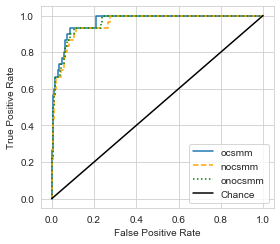

<Figure size 432x288 with 0 Axes>

In [5]:
plot_roc_curves(y_test, y_hat_dict)

# Group Anomalies Panel

In [8]:
from utils_data.synthetic_mixtures import generate_mixtures_panel

mixtures_panel_df = generate_mixtures_panel(n_u_id=2, n_dates=100)

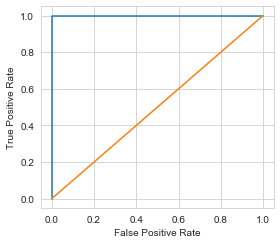

<Figure size 432x288 with 0 Axes>

In [9]:
train_filter = (mixtures_panel_df.loc[0, 'split'] == 'train')
validation_filter = (mixtures_panel_df.loc[0, 'split'] == 'validation')

Strain = mixtures_panel_df.loc[0, 'set'][train_filter]
Stest = mixtures_panel_df.loc[0, 'set'][validation_filter]
y_test = mixtures_panel_df.loc[0, 'outlier'][validation_filter]

clf = OnlineNystroemOneClassSMM(C=0.1, gamma=0.1, n_components=10, learning_rate="optimal")
clf.fit(Strain)
outlier_score_test = clf.outlier_score(Stest)

plot_roc_curve(y_test, outlier_score_test)

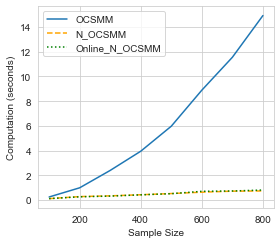

<Figure size 432x288 with 0 Axes>

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import time
from utils_data.synthetic_mixtures import generate_mixtures
from utils_visualization import plot_sample_size_times

from models.ocsmm import OneClassSMM
from models.nystroem_ocsmm import NystroemOneClassSMM
from models.nystroem_ocsmm import OnlineNystroemOneClassSMM

def sample_size_time_comparison():
    ocsmm_times, nocsmm_times, onocsmm_times = [], [], []
    ns = [100, 200, 300, 400, 500, 600, 700, 800]
    for n in ns:
        mixtures_df = generate_mixtures(n=n)
        train_mixtures = mixtures_df.loc[mixtures_df['split'] == 'train']
        test_mixtures = mixtures_df.loc[mixtures_df['split'] == 'test']

        Strain = train_mixtures['set'].tolist()
        Stest = test_mixtures['set'].tolist()
        y_test = test_mixtures['outlier'].tolist()
        
        # OCSMM
        clf = OneClassSMM(C=0.1, gamma=0.1)
        start = time.clock()
        clf.fit(Strain)
        end = time.clock()
        ocsmm_times.append(end - start)

        # Nystroem OCSMM
        clf = NystroemOneClassSMM(C=0.1, gamma=0.1, n_components=10)
        start = time.clock()
        clf.fit(Strain)
        end = time.clock()
        nocsmm_times.append(end - start)
        
        # Online Nystroem OCSMM
        clf = OnlineNystroemOneClassSMM(C=0.1, gamma=0.1, n_components=10)
        start = time.clock()
        clf.fit(Strain)
        end = time.clock()
        onocsmm_times.append(end - start)
    
    plot_sample_size_times(ns, ocsmm_times, nocsmm_times, onocsmm_times)
        
sample_size_time_comparison()

In [11]:
import numpy as np

import time

from utils_visualization import plot_rolling_window_times

from models.nystroem_ocsmm import NystroemOneClassSMM
from models.nystroem_ocsmm import OnlineNystroemOneClassSMM

def rolling_window_time_comparison(window_size):
    nocsmm_times, onocsmm_times = [], []
    ns = [100, 200, 300, 400, 500, 600, 700, 800]
    #ns = [100, 200]
    
    nocsmm_times, onocsmm_times = [], []
    for n in ns:
        mixtures_df = generate_mixtures(n=n)
        
        y = mixtures_df['set'].to_numpy()
        y_train = y[:window_size]
        
        # initialize detectors
        nocsmm = NystroemOneClassSMM(C=0.1, gamma=0.1, n_components=10)
        nocsmm.fit(y[:window_size])
        online_nocsmm = OnlineNystroemOneClassSMM(C=0.1, gamma=0.1, n_components=10)
        online_nocsmm.fit(y[:window_size])

        n_dates = len(y[window_size:])
        nocsmm_time, onocsmm_time = 0, 0
        for idx_iter in range(window_size, n_dates, 10):
            val = y[idx_iter:idx_iter+10]

            # update
            start = time.clock()
            nocsmm.fit(y_train)
            end = time.clock()
            nocsmm_time += end-start

            start = time.clock()
            online_nocsmm.fit(val)
            end = time.clock()
            onocsmm_time += end-start
        
        nocsmm_times.append(nocsmm_time)
        onocsmm_times.append(onocsmm_time)
    
    steps = np.array(ns) - window_size
    plot_rolling_window_times(steps, nocsmm_times, onocsmm_times)
    
    return nocsmm_times, onocsmm_times


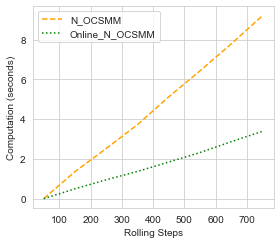

<Figure size 432x288 with 0 Axes>

In [12]:
from utils_data.synthetic_mixtures import generate_mixtures
from utils_visualization import plot_mixtures
from utils_visualization import plot_roc_curve

# mixtures_df = generate_mixtures(100)
# train_mixtures = mixtures_df.loc[mixtures_df['split'] == 'train']
# test_mixtures = mixtures_df.loc[mixtures_df['split'] == 'test']
# plot_mixtures(mixtures_df.loc[mixtures_df['split'] == 'test'])

nocsmm_times, onocsmm_times = rolling_window_time_comparison(window_size=50)